In [26]:
import os
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, ReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,LearningRateScheduler, EarlyStopping
from keras.utils import plot_model
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [27]:
K.clear_session()

In [28]:
from tensorflow.keras.datasets import mnist
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

trainX=trainX/255
testX=testX/255

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


In [45]:
def step_decay(epoch):

    initial_lrate=0.001
    step_size=10
    decay_factor=0.5
    new_lr=initial_lrate * (decay_factor ** np.floor(epoch/step_size))
    print(new_lr,epoch)
    return new_lr

class AutoEncoder():

    _ENC_FILTERS = [32,64,64,64]
    _ENC_STRIDES = [1,2,2,1]
    _FILTER_SIZE = [3,3,3,3]
    _DEC_FILTERS = [64,64,32,1]
    _DEC_STRIDES = [1,2,2,1]
    _BATCH_NORM = True
    _DROPOUT = 0.2

    def __init__(self,input_dim, latent_space):

        self.input_dim = input_dim
        self.latent = latent_space

    def _build_encoder(self):

        encoder_input = Input(shape=self.input_dim,name='encoder_input')
        x=encoder_input

        for lyr in range(len(self._ENC_FILTERS)):

            conv_layer = Conv2D(filters = self._ENC_FILTERS[lyr],
                              kernel_size = self._FILTER_SIZE[lyr],
                              strides = self._ENC_STRIDES[lyr],
                              name = 'encoder_conv'+str(lyr),
                              padding ='same')
            x = conv_layer(x)
            x = ReLU()(x)

            if self._BATCH_NORM == True:
                x = BatchNormalization()(x)

        shape_before_flattening = K.int_shape(x)[1:]
        x = Flatten()(x)
        encoder_output = Dense(self.latent, name = 'encoder_output')(x)
        encoder = Model(encoder_input, encoder_output, name = 'Encoder')

        return encoder

    def _build_decoder(self,shape_before_flattening):

        decoder_input = Input(shape = self.latent,name = 'decoder_input')
        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for lyr in range(len(self._DEC_FILTERS)):

            conv_t_layer = Conv2DTranspose(filters = self._DEC_FILTERS[lyr],
                                         kernel_size = self._FILTER_SIZE[lyr],
                                         strides=self._DEC_STRIDES[lyr],
                                         name = 'decoder_conv_t'+str(lyr),
                                         padding = 'same')
            x = conv_t_layer(x)

            if lyr<len(self._DEC_FILTERS)-1:

                x = ReLU()(x)

                if self._BATCH_NORM == True:
                    x = BatchNormalization()(x)
            else:
                x=Activation('sigmoid')(x)

        decoder_output = x
        decoder = Model(decoder_input,decoder_output, name = 'Decoder')
        return decoder

    def fit(self,Xtr,Xval,**kwargs):

        self.initial_lr = kwargs.get("initial_lr", 0.001)
        self.batch_size = kwargs.get("batch_size", 32)
        self.callbacks_list = kwargs.get("callbacks_list", [])
        self.epochs = kwargs.get("epochs", 100)
        self.shuffle = kwargs.get("shuffle", True)

        model, decoder, encoder = self.get_model()

        model.fit(Xtr, Xtr,
                       batch_size = self.batch_size,
                       validation_data = (Xval,Xval),
                       shuffle = self.shuffle,
                       epochs = self.epochs,
                       callbacks = self.callbacks_list)

        self.model = model
        self.decoder = decoder
        self.encoder = encoder


    def get_model(self):

        #Autoencoder Layer
        encoder = self._build_encoder()
        shape_before_flattening = encoder.layers[-5].get_output_at(0).get_shape().as_list()[1:]
        decoder = self._build_decoder(shape_before_flattening)

        model_input = Input(shape=self.input_dim,name = 'encoder_input')
        encoder_op = encoder(model_input)
        decoder_op = decoder(encoder_op)

        model = Model(model_input,decoder_op,name = 'ae_model')

        model.compile(optimizer = Adam(learning_rate = 0.001),
                           loss = 'mean_squared_error',
                           )

        return model, decoder, encoder

In [49]:
ae = AutoEncoder(input_dim=(28,28,1), latent_space = 16)
model, decoder, encoder = ae.get_model()
model.summary()

Model: "ae_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 Encoder (Functional)        (None, 16)                143760    
                                                                 
 Decoder (Functional)        (None, 28, 28, 1)         146561    
                                                                 
Total params: 290,321
Trainable params: 289,553
Non-trainable params: 768
_________________________________________________________________


Model: "ae_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 Encoder (Functional)        (None, 32)                193952    
                                                                 
 Decoder (Functional)        (None, 28, 28, 1)         196737    
                                                                 
Total params: 390,689
Trainable params: 389,921
Non-trainable params: 768
_________________________________________________________________


In [44]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)
callbacks_list=[early_stopper]
ae.fit(trainX,testX)

Epoch 1/100
1875/1875 [==============================] - 24s 9ms/step - loss: 0.0127 - val_loss: 0.0072
Epoch 2/100
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 3/100
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 4/100
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 5/100
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 6/100
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 7/100
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 8/100
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 9/100
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 10/100
1875/1875 [==============================] - 17s 9m

KeyboardInterrupt: 

1/1 [==============================] - 2s 2s/step


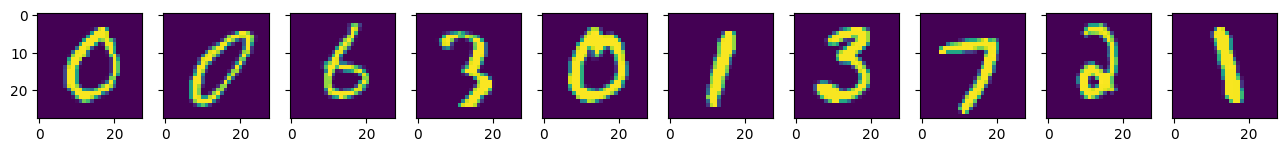

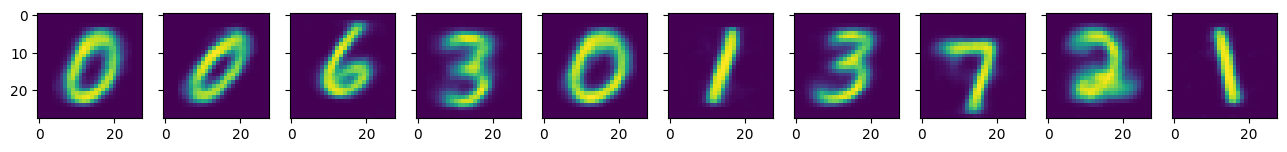

In [47]:
samples = np.random.randint(0,testX.shape[0],10)
fig,axn=plt.subplots(1,10,sharex='col',sharey='row',figsize=(16,1.8))
for n,i in enumerate(samples):
    axn[n].imshow(testX[i])


testX_recons = dec.model.predict(testX[samples])[1]
fig,axn=plt.subplots(1,10,sharex='col',sharey='row',figsize=(16,1.8))
for n,i in enumerate(testX_recons):
    axn[n].imshow(i)

1/1 [==============================] - 2s 2s/step


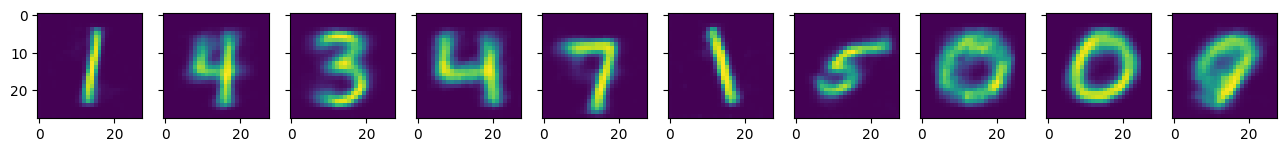

In [48]:
samples = np.random.randint(0,testX.shape[0],10)
random_samples = testX[samples]

latent_samples = dec.encoder.predict(testX[samples])
recons_samples = dec.decoder.predict(latent_samples)

fig,axn=plt.subplots(1,10,sharex='col',sharey='row',figsize=(16,1.8))
for n,i in enumerate(recons_samples):
    axn[n].imshow(recons_samples[n,::,::,0])

In [49]:
model_out = dec.model.predict(testX)[0]
y_preds = np.argmax(model_out,axis = 1)

313/313 [==============================] - 4s 4ms/step


In [52]:
from sklearn.metrics import classification_report
print(classification_report(testy, y_preds))

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
cluster_centers = dec.model.layers[-1].clusters.numpy()
labels = np.argmax(dec.model.predict(testX)[2],axis=1).squeeze()

In [50]:
!pip install sklearn

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2970 sha256=b1929ed1b279b39ca967dc2d2fb4a8c95a2e020ff88e468e766125961954c902
  Stored in directory: c:\users\arind\appdata\local\pip\cache\wheels\36\49\c9\2374f1dee1b599effabf63d948635e6608f62d0ccde027b7e2
Successfully built sklearn


In [53]:
import sklearn

ModuleNotFoundError: No module named 'sklearn'